# データの取得、整形

In [59]:
import sys
sys.path

['d:\\DEV\\competition\\text\\signate_classfication_medical_papers',
 'd:\\masa\\Anaconda3\\python38.zip',
 'd:\\masa\\Anaconda3\\DLLs',
 'd:\\masa\\Anaconda3\\lib',
 'd:\\masa\\Anaconda3',
 '',
 'C:\\Users\\masa\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'd:\\masa\\Anaconda3\\lib\\site-packages',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\geoplot-0.4.1-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\contextily-1.0.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\mapclassify-2.3.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\descartes-1.1.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\win32',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\Pythonwin']

In [22]:
import pandas as pd

In [23]:
df = pd.read_csv("train.csv", index_col=0)

In [24]:
df["abstract"]=df["abstract"].where(df["abstract"].notna(),df["title"])

In [25]:
df.head()

,title,abstract,judgement
id,,,
0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderly...,0


In [64]:
len(df)

27145

## インストール

In [65]:
#!pip install ipython -U

In [66]:
# ライブラリのインストール
#!python -m pip install --upgrade pip
#!pip install -U fugashi ipadic \
#    transformers lime captum\
#    scikit-learn numpy --user


# データローラーなど

In [26]:
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'abstract': row.abstract,
                'judgement': row.judgement
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

train_df, eval_df = train_test_split(df, train_size=0.8)
#eval_df, test_df = train_test_split(eval_df, train_size=0.5)

train_dataset = CustomDataset(train_df)
eval_dataset = CustomDataset(eval_df)
#test_dataset = CustomDataset(test_df)

100%|██████████| 5429/5429 [00:00<00:00, 777773.56it/s]


In [80]:
import collections

l = train_df.judgement

c = collections.Counter(l)
print(c)

Counter({0: 21201, 1: 515})


In [81]:
import collections

l = eval_df.judgement

c = collections.Counter(l)
print(c)

Counter({0: 5312, 1: 117})


In [60]:
import torch
from transformers import AutoTokenizer

class CustomCollator():
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, examples):
        try:
            examples = {
                'abstract': list(map(lambda x: x['abstract'], examples)),
                'judgement': list(map(lambda x: x['judgement'], examples))
            }
        except:
            examples = {
                'abstract': list(map(lambda x: x['abstract'], examples))
            }
        encodings = self.tokenizer(examples['abstract'],
                                   padding=True,
                                   truncation=True,
                                   max_length=self.max_length,
                                   return_tensors='pt')
        if 'judgement' in examples:
            encodings['judgement'] = torch.tensor(examples['judgement'])
        return encodings
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
custom_collator = CustomCollator(tokenizer)

loading configuration file config.json from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\vocab.txt

In [11]:
# ライブラリのインポート
import os
import re
import sys

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
from torch.nn import functional as F
import transformers
from sklearn.model_selection import train_test_split

In [12]:
# BERTモデルの動作デバイス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Function
import numpy as np


class FocalLossWithOutOneHot(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLossWithOutOneHot, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        logit = F.softmax(input, dim=1)
        logit = logit.clamp(self.eps, 1. - self.eps)
        logit_ls = torch.log(logit)
        loss = F.nll_loss(logit_ls, target, reduction="none")
        view = target.size() + (1,)
        index = target.view(*view)
        loss = loss * (1 - logit.gather(1, index).squeeze(1)) ** self.gamma # focal loss
        return loss.sum()

In [3]:
import torch.nn as nn
from transformers import AutoModel
from transformers.modeling_outputs import ModelOutput

class CustomNet(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function
    
    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                judgement=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            token_type_ids=token_type_ids,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states)
        
        state = outputs.last_hidden_state[:, 0, :]
        state = self.linear(state)
        
        loss=None
        if judgement is not None and self.loss_function is not None:
            loss = self.loss_function(state, judgement)
        
        attentions=None
        if output_attentions:
            attentions=outputs.attentions
        
        hidden_states=None
        if output_hidden_states:
            hidden_states=outputs.hidden_states
        print(state)
        return ModelOutput(
            logits=state,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )

categories = [0,1]
loss_fct = FocalLossWithOutOneHot()
pretrained_model = AutoModel.from_pretrained('bert-base-uncased')
model = CustomNet(pretrained_model, len(categories), loss_fct)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
model.load_state_dict(torch.load("output\model\prod\pytorch_model.bin"))

<All keys matched successfully>

In [115]:
for name,param in model.named_parameters():
    param.requires_grad = False

#BERTの最上位層（１２層目）とその下の層（11層目）をアクティブにする
for name, param in model.bert.encoder.layer[11].named_parameters():
    param.requires_grad = True

for name, param in model.bert.encoder.layer[10].named_parameters():
    param.requires_grad = True

In [8]:
model = model.to(device)

# Fine tunining

In [13]:
optimizer = transformers.AdamW(model.parameters(), lr=1e-4)

C:\Users\masa\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
from transformers import EvalPrediction
from typing import Dict
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    fbeta = fbeta_score(target, pred, beta = 7, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fbeta' : fbeta
    }

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./output/model',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    label_names=['judgement'],
    lr_scheduler_type='polynomial',
    metric_for_best_model='fbeta',
    load_best_model_at_end=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    remove_unused_columns=False
)

In [16]:
model

CustomNet(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [61]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=custom_collator,
    compute_metrics=custom_compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)



In [ ]:
trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'])
trainer.save_model("output/model/prod")

In [ ]:
categories = [0,1]


In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

preds_output = trainer.predict(eval_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(eval_df["judgement"])



***** Running Prediction *****
  Num examples = 5429
  Batch size = 8


  0%|          | 0/679 [00:00<?, ?it/s]

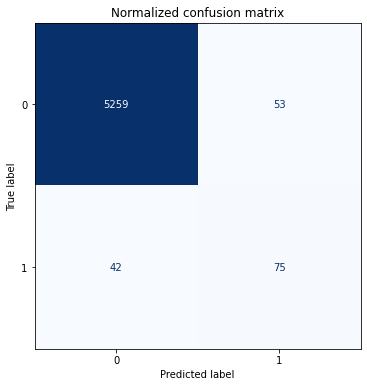

In [122]:
def plot_confusion_matrix(y_preds, y_true, categories):
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, categories)

In [66]:
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class TestDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'abstract': row.abstract
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

test_df = pd.read_csv("test.csv", index_col=0)
test_df["abstract"]=test_df["abstract"].where(test_df["abstract"].notna(),test_df["title"])

test_dataset = TestDataset(test_df)






100%|██████████| 40834/40834 [00:00<00:00, 929861.23it/s]
***** Running Prediction *****
  Num examples = 40834
  Batch size = 8


KeyboardInterrupt: 

In [69]:
result = trainer.predict(test_dataset[0:2], ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

***** Running Prediction *****
  Num examples = 2
  Batch size = 8


In [70]:
result

PredictionOutput(predictions=array([[ 5.5383935, -5.2530723],
       [ 3.457717 , -2.8394465]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.7026, 'test_samples_per_second': 2.846, 'test_steps_per_second': 1.423})

In [123]:
trainer.save_model("output/model/prod")

Saving model checkpoint to output/model/prod
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in output/model/prod\tokenizer_config.json
Special tokens file saved in output/model/prod\special_tokens_map.json


In [125]:
class SubmitDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'abstract': row.abstract
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

In [138]:
submit_df = pd.read_csv("test.csv", index_col=0)
submit_df["abstract"]=submit_df["abstract"].where(submit_df["abstract"].notna(),submit_df["title"])
submit_df['judgement'] = [0] * len(submit_df)
submit_dataset = CustomDataset(submit_df)



100%|██████████| 40834/40834 [00:00<00:00, 314942.63it/s]


In [135]:
submit_df["abstract"]=submit_df["abstract"].where(submit_df["abstract"].notna(),submit_df["title"])

In [139]:
submit_df

,title,abstract,judgement
id,,,
27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,0
27146,Leukoerythroblastic reaction in a patient with...,Leukoerythroblastic reaction in a patient with...,0
27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,0
27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,0
27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,0
...,...,...,...
67974,"Knowledge, Attitude, and Practices of Healthca...",In the current outbreak of novel coronavirus (...,0
67975,Safety and Efficacy of Anti-Il6-Receptor Tocil...,BACKGROUND: As the novel SARS-CoV-2 pandemic o...,0
67976,Functional imaging of head and neck tumors usi...,Positron emission tomography (PET) is an imagi...,0


In [140]:
result = trainer.predict(submit_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

***** Running Prediction *****
  Num examples = 40834
  Batch size = 8


  0%|          | 0/5105 [00:00<?, ?it/s]

d:\masa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 

In [73]:
result

PredictionOutput(predictions=array([[ 5.5383935, -5.2530723],
       [ 3.457717 , -2.8394465]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.7026, 'test_samples_per_second': 2.846, 'test_steps_per_second': 1.423})

In [71]:
softmax_fn = nn.Softmax(dim=1)
softmax_output = softmax_fn(result[0])


AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [72]:
result[0]

array([[ 5.5383935, -5.2530723],
       [ 3.457717 , -2.8394465]], dtype=float32)

In [22]:
import pandas as pd
import os

df = pd.read_pickle('./input/livedoor_data.pickle')
# カテゴリーのID列を付与しておく
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

df.sample(3)

FileNotFoundError: [Errno 2] No such file or directory: './input/livedoor_data.pickle'